In [1]:
#.csv files in this archive are in the following format:
# The first row is the initial time of the session expressed as unix timestamp in UTC.
# The second row is the sample rate expressed in Hz.

# TEMP.csv
# Data from temperature sensor expressed degrees on the Celsius (°C) scale.

# EDA.csv
# Data from the electrodermal activity sensor expressed as microsiemens (μS).

# BVP.csv
# Data from photoplethysmograph.

# ACC.csv
# Data from 3-axis accelerometer sensor. The accelerometer is configured to measure acceleration in the range [-2g, 2g]. Therefore the unit in this file is 1/64g.
# Data from x, y, and z axis are respectively in first, second, and third column.

# IBI.csv
# Time between individuals heart beats extracted from the BVP signal.
# No sample rate is needed for this file.
# The first column is the time (respect to the initial time) of the detected inter-beat interval expressed in seconds (s).
# The second column is the duration in seconds (s) of the detected inter-beat interval (i.e., the distance in seconds from the previous beat).

# HR.csv
# Average heart rate extracted from the BVP signal.The first row is the initial time of the session expressed as unix timestamp in UTC.
# The second row is the sample rate expressed in Hz.


# tags.csv
# Event mark times.
# Each row corresponds to a physical button press on the device; the same time as the status LED is first illuminated.
# The time is expressed as a unix timestamp in UTC and it is synchronized with initial time of the session indicated in the related data files from the corresponding session.

In [2]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime
import warnings
warnings.filterwarnings("ignore")

In [3]:
hr_raw = pd.read_csv('../EMP006/1506098656_A014F2/HR.csv',header = None, names=['HR'])
eda_raw = pd.read_csv('../EMP006/1506098656_A014F2/EDA.csv',header = None, names=['eda'])
bvp_raw = pd.read_csv('../EMP006/1506098656_A014F2/BVP.csv',header = None, names=['bvp'])

In [4]:
def video_time(path):
    interval = pd.read_csv(path, sep = ',')
    video_start = pd.to_datetime(interval.time[0]).timestamp()
    video_end = pd.to_datetime(interval.time[1]).timestamp()
    return video_start,video_end

In [5]:
video_start,video_end = video_time('../EMP006_blackbox/EMP006_8_2017-09-22_18_49_53/EMP006_8_2017-09-22_18_49_53_drive.csv')


In [6]:
video_start,video_end,pd.to_datetime(video_start, unit='s') 

(1506106193.696369, 1506106767.268014, Timestamp('2017-09-22 18:49:53.696369'))

In [7]:
def data_modify(df):
    # first two rows
    start_time = df.iloc[0,0]
    sample_rate = 1/df.iloc[1,0]
    # reset 
    df = df.iloc[2:].reset_index(drop=True)
    # utc timestamp
    unix_time = pd.Series(range(0,len(df)))*sample_rate + start_time
    df.insert(loc=0, column='unix_time', value=unix_time)
    # interest df
    df_i = df[(df.unix_time > video_start) & (df.unix_time < video_end)]
    # utc 
    df_i.insert(loc=1, column='utc_time', value = pd.to_datetime(df_i.unix_time, unit='s'))
    # time
    df_i.insert(loc=2, column='time', value = df_i.apply(lambda row:
                                                         row['utc_time'].hour*3600+
                                                         row['utc_time'].minute*60+
                                                         row['utc_time'].second+
                                                         row['utc_time'].microsecond/1000000, axis=1))
    df_i = df_i.reset_index(drop=True)
    return df_i


In [8]:
hr_i = data_modify(hr_raw)
eda_i = data_modify(eda_raw)
bvp_i = data_modify(bvp_raw)

In [9]:
hr_i.time[0],eda_i.time[0],bvp_i.time[0]

(67794.0, 67793.75, 67793.703125)

Text(0.5,0,'eda frequency')

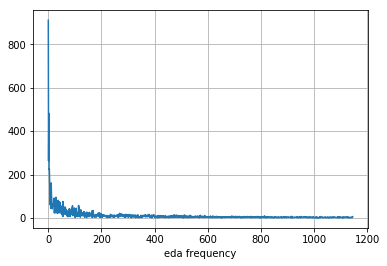

In [10]:
# FFT
from numpy import fft
edaFFT = np.fft.fft(eda_i.eda)
plt.plot(abs(edaFFT[1:len(edaFFT)//2]))
plt.grid(True)
plt.xlabel('eda frequency')

In [11]:
# denoise
threshold = 100
mask = abs(edaFFT) > threshold
eda_DEnoise_FFT = edaFFT * mask
eda_DEnoise_iFFT = np.fft.ifft(eda_DEnoise_FFT)

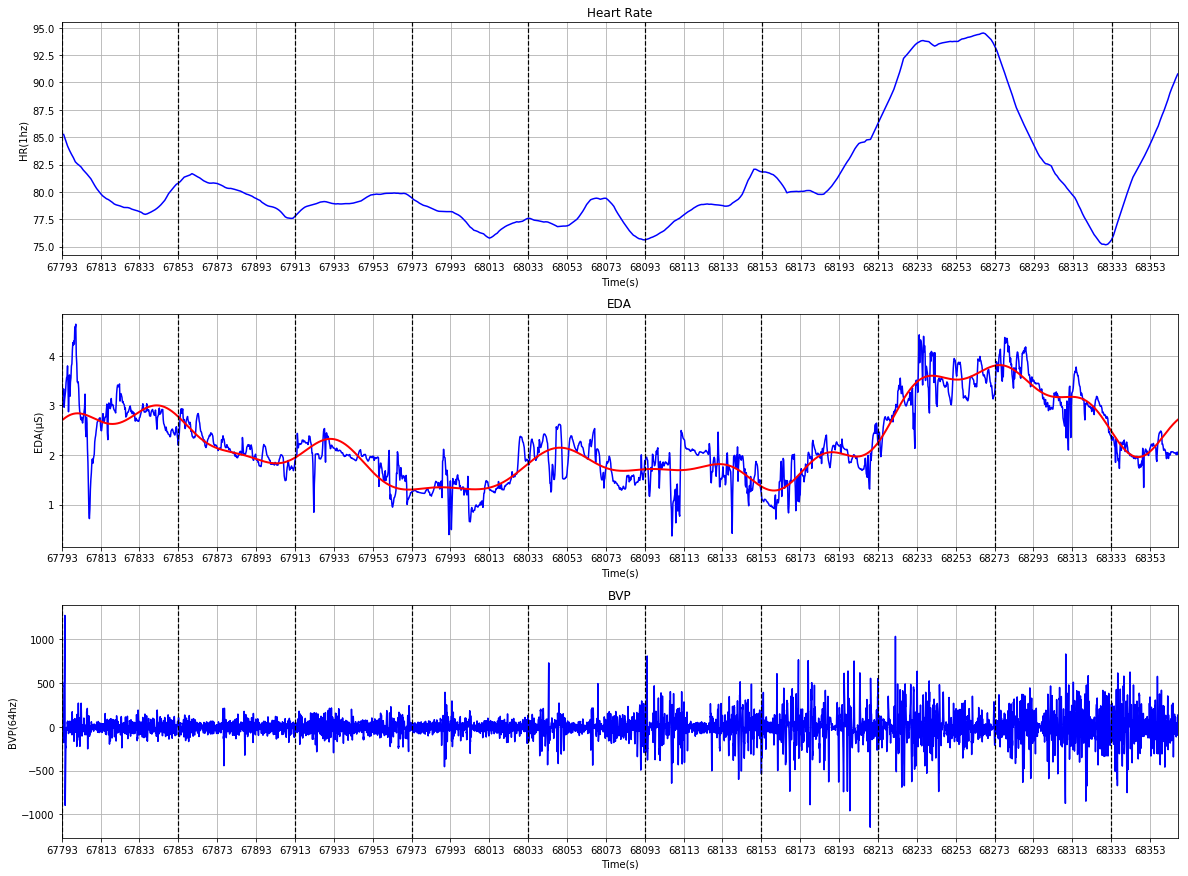

In [12]:
# time series data plot
from ipywidgets import interact, interactive, fixed
from matplotlib import gridspec
fig= plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(3, 1, wspace=0.05, hspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

blocks = (np.arange(int(hr_i.time.min()-1), int(bvp_i.time.max()), 60)).tolist()


ax0.plot(hr_i.time, hr_i.HR, alpha = 1, color = 'b')
ax0.set_xlabel('Time(s)')
ax0.set_ylabel('HR(1hz)')
ax0.set_xlim([hr_i.time.min()-1, hr_i.time.max()])
ax0.set_xticks(range(int(hr_i.time.min()-1),int(hr_i.time.max()),20))
#ax0.set_ylim(yrange)
#ax0.set_yticks(ytick)
ax0.set_title('Heart Rate')
ax0.grid(True)
for vline in blocks:
    ax0.axvline(x=vline, color = 'black', linestyle = '--', linewidth=1.2)

ax1.plot(eda_i.time, eda_i.eda, alpha = 1,color='b')
ax1.plot(eda_i.time, eda_DEnoise_iFFT, linewidth=2.0, color = 'red')

ax1.set_xlabel('Time(s)')
ax1.set_ylabel('EDA(μS)')
ax1.set_xlim([eda_i.time.min(), eda_i.time.max()])
ax1.set_xticks(range(int(eda_i.time.min()),int(eda_i.time.max()),20))
#ax1.set_ylim(yrange)
#ax1.set_yticks(ytick)
ax1.set_title('EDA')
ax1.grid(True)
for vline in blocks:
    ax1.axvline(x=vline, color = 'black', linestyle = '--', linewidth=1.2)

ax2.plot(bvp_i.time, bvp_i.bvp, alpha = 1, color = 'b')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('BVP(64hz)')
ax2.set_xlim([bvp_i.time.min(), bvp_i.time.max()])
ax2.set_xticks(range(int(bvp_i.time.min()),int(bvp_i.time.max()),20))
#ax2.set_ylim([0,60])
#ax2.set_yticks(range(0, 60, 5))
ax2.set_title('BVP')
ax2.grid(True)
for vline in blocks:
    ax2.axvline(x=vline, color = 'black', linestyle = '--', linewidth=1.2)


In [13]:
# 1min interesting
start_1min = 68033
end_1min = start_1min + 60
hr_1min = hr_i[(hr_i.time > start_1min) & (hr_i.time < end_1min)].reset_index(drop=True)
eda_1min = eda_i[(eda_i.time > start_1min) & (eda_i.time < end_1min)].reset_index(drop=True)
bvp_1min = bvp_i[(bvp_i.time > start_1min) & (bvp_i.time < end_1min)].reset_index(drop=True)

In [14]:
hr_1min.time[0],eda_1min.time[0],bvp_1min.time[0]

(68034.0, 68033.25, 68033.015625)

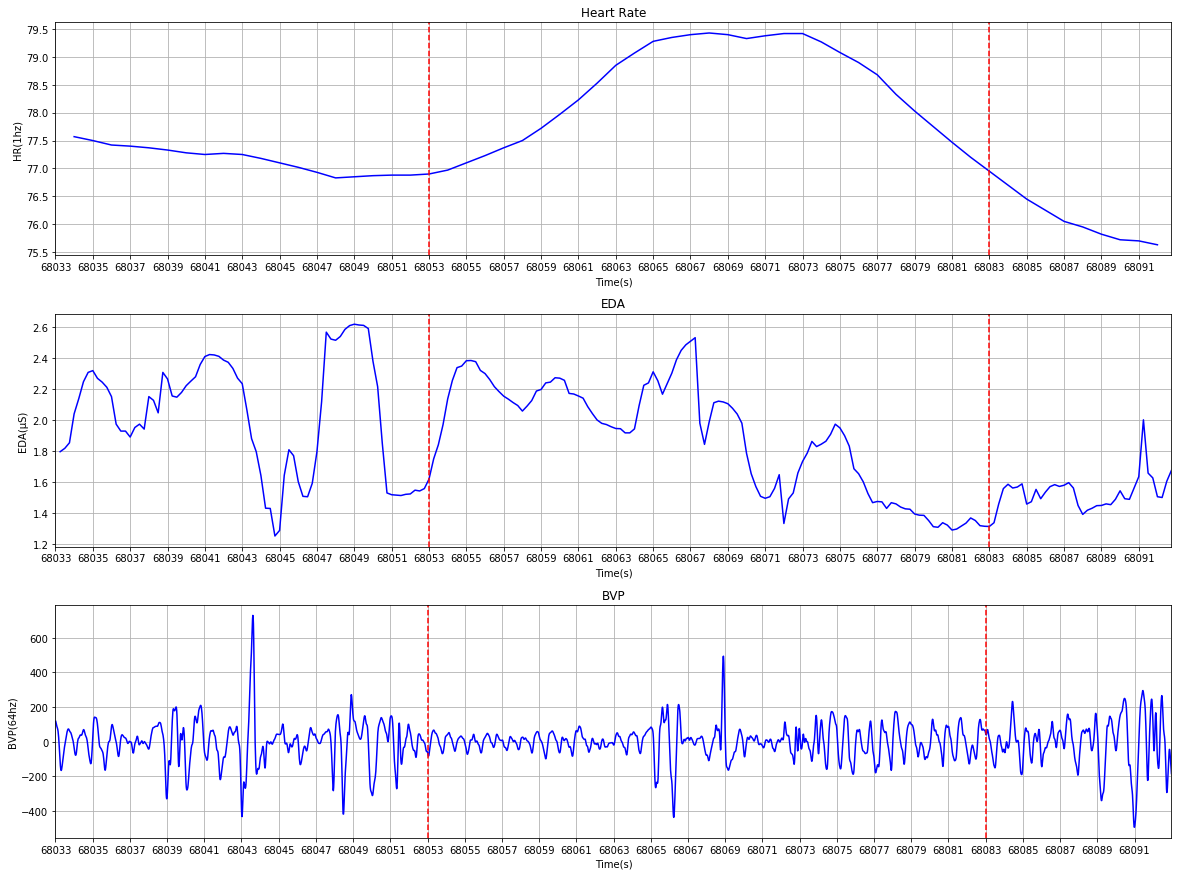

In [15]:
# 1min time series data plot
from ipywidgets import interact, interactive, fixed
from matplotlib import gridspec
fig= plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(3, 1, wspace=0.05, hspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

#yrange = [0,90]
#ytick = range(0, 100, 10)
#xrange = [4,20]
#xtick = range(4, 21, 1)
#read data
#speed = hr_i['Speed']
#time = data['Time']/3600
#Occu = data['Occu']

ax0.plot(hr_1min.time, hr_1min.HR, alpha = 1, color = 'b')
ax0.set_xlabel('Time(s)')
ax0.set_ylabel('HR(1hz)')
ax0.set_xlim([hr_1min.time.min()-.75, hr_1min.time.max()+.75])
ax0.set_xticks(range(int(hr_1min.time.min()-1),int(hr_1min.time.max()+1),2))
#ax0.set_ylim(yrange)
#ax0.set_yticks(ytick)
ax0.set_title('Heart Rate')
ax0.grid(True)
ax0.axvline(x=68053, color = 'red', linestyle = '--', linewidth=1.5)
ax0.axvline(x=68083, color = 'red', linestyle = '--', linewidth=1.5)

ax1.plot(eda_1min.time, eda_1min.eda, alpha = 1,color='b')
#ax1.plot(eda_1min.time, eda_DEnoise_iFFT, linewidth=2.0, color = 'red')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('EDA(μS)')
ax1.set_xlim([eda_1min.time.min(), eda_1min.time.max()])
ax1.set_xticks(range(int(eda_1min.time.min()),int(eda_1min.time.max()),2))
#ax1.set_ylim(yrange)
#ax1.set_yticks(ytick)
ax1.set_title('EDA')
ax1.grid(True)
ax1.axvline(x=68053, color = 'red', linestyle = '--', linewidth=1.5)
ax1.axvline(x=68083, color = 'red', linestyle = '--', linewidth=1.5)

ax2.plot(bvp_1min.time, bvp_1min.bvp, alpha = 1, color = 'b')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('BVP(64hz)')
ax2.set_xlim([bvp_1min.time.min(), bvp_1min.time.max()])
ax2.set_xticks(range(int(bvp_1min.time.min()),int(bvp_1min.time.max()),2))
#ax2.set_ylim([0,60])
#ax2.set_yticks(range(0, 60, 5))
ax2.set_title('BVP')
ax2.grid(True)
ax2.axvline(x=68053, color = 'red', linestyle = '--', linewidth=1.5)
ax2.axvline(x=68083, color = 'red', linestyle = '--', linewidth=1.5)

In [16]:
eda_1min.unix_time.min(), eda_1min.unix_time.max()

(1506106433.25, 1506106492.75)

In [ ]:
eda_1min['ticks'] = eda_1min['time']-int(eda_1min['time'].min())
hr_1min['ticks'] = hr_1min['time']-int(eda_1min['time'].min())

In [ ]:
fig= plt.figure(figsize=(7.52,9.60), dpi=100)
gs = gridspec.GridSpec(2, 1, wspace=0.05, hspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

#yrange = [0,90]
#ytick = range(0, 100, 10)
xrange = [0,60]
xtick = range(0,60,2)

ax0.plot(hr_1min.ticks, hr_1min.HR, alpha = 1, color = 'b')
ax0.set_xlabel('Time(s)')
ax0.set_ylabel('HR(1hz)')
ax0.set_xlim(xrange)
ax0.set_xticks(xtick)
#ax0.set_title('Heart Rate')
ax0.grid(True)

ax1.plot(eda_1min.ticks, eda_1min.eda, alpha = 1,color='b')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('EDA(μS)')
ax1.set_xlim(xrange)
ax1.set_xticks(xtick)
#ax1.set_title('EDA')
ax1.grid(True)

In [ ]:
@interact
def data_visual(i:(0,60,0.25)=0):
    fig= plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 1, wspace=0.05, hspace=0.25)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    xrange = [0,60]
    xtick = range(0,60,2)

    ax0.plot(hr_1min.ticks, hr_1min.HR, alpha = 1, color = 'b')
    ax0.set_xlabel('Time(s)')
    ax0.set_ylabel('HR(1hz)')
    ax0.set_xlim(xrange)
    ax0.set_xticks(xtick)

    ax0.grid(True)

    ax1.plot(eda_1min.ticks, eda_1min.eda, alpha = 1,color='b')
    ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('EDA(μS)')
    ax1.set_xlim(xrange)
    ax1.set_xticks(xtick)
    #ax1.set_title('EDA')
    ax1.grid(True)

    ax1.axvline(x=i, color = 'red', linestyle = '-', linewidth=1)
    ax0.axvline(x=i, color = 'red', linestyle = '-', linewidth=1)

In [ ]:
for i in range(0,1526,1):
    fig= plt.figure(figsize=(7.52,9.60), dpi=100)
    gs = gridspec.GridSpec(2, 1, wspace=0.05, hspace=0.25)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    xrange = [0,60]
    xtick = range(0,60,2)

    ax0.plot(hr_1min.ticks, hr_1min.HR, alpha = 1, color = 'b')
    ax0.set_xlabel('Time(s)')
    ax0.set_ylabel('HR(1hz)')
    ax0.set_xlim(xrange)
    ax0.set_xticks(xtick)
    ax0.grid(True)

    ax1.plot(eda_1min.ticks, eda_1min.eda, alpha = 1,color='b')
    ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('EDA(μS)')
    ax1.set_xlim(xrange)
    ax1.set_xticks(xtick)
    #ax1.set_title('EDA')
    ax1.grid(True)

    ax0.axvline(x=float(i/(1526/60)), color = 'red', linestyle = '-', linewidth=1)
    ax1.axvline(x=float(i/(1526/60)), color = 'red', linestyle = '-', linewidth=1)
    
    fig.savefig('dt_frame/{}.png'.format(i))